In [1]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.triplet_functions import n_neurons
import pandas as pd


init_gpu.initialize_gpus()

locations = ['LOC1', 'LOC2']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)

train_df.head()

2024-10-31 11:57:36.881470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 11:57:36.888116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 11:57:36.896066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 11:57:36.898435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 11:57:36.904325: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  2
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/asil0892/doh_traffic_analysis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


Location  Website         0         1         2         3         4  \
0     LOC1        0 -1.086861  0.690199  0.647933  0.201517  0.207139   
1     LOC1     1005  1.095547 -1.585943  0.647933  0.343653  0.207139   
2     LOC1     1005  1.095547  0.780047 -1.972790  0.343653  0.207139   
3     LOC1     1005 -1.086861  0.690199  0.647933  0.343653  0.207139   
4     LOC1     1005  1.095547  0.780047  0.183501 -0.828965 -2.083179   

          5         6         7  ...       116       117       118       119  \
0 -0.031855 -0.316768  0.824649  ...  0.055571  0.160203  0.121677  0.093533   
1 -0.031855 -0.316768  0.824649  ...  0.055571  0.160203  0.121677  0.093533   
2 -0.031855 -0.316768  0.824649  ...  0.055571  0.160203  0.121677  0.093533   
3 -0.031855 -0.316768  0.824649  ...  0.055571  0.160203  0.121677  0.093533   
4 -0.031855 -0.316768  0.824649  ...  0.055571  0.160203  0.121677  0.093533   

       120       121       122       123       124      125  
0  0.09274  0.057062  0.155991  0.109839  0.086282  0.08604  
1  0.09274  0.057062  0.155991  0.109839  0.086282  0.08604  
2  0.09274  0.057062  0.155991  0.109839  0.086282  0.08604  
3  0.09274  0.057062  0.155991  0.109839  0.086282  0.08604  
4  0.09274  0.057062  0.155991  0.109839  0.086282  0.08604  

[5 rows x 128 columns]

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from scripts.train_vae import DenseVAE, Sampling

class DomainAlignmentNetwork(keras.Model):
    def __init__(self, input_dim, **kwargs):
        """
        Args:
            input_dim: Dimension of input latent space (input_vae's latent dim)
            hidden_dims: List of hidden layer dimensions
        """
        super(DomainAlignmentNetwork, self).__init__(**kwargs)
        
        self.input_dim = input_dim     
        self.alignment_network = keras.Sequential([
            keras.layers.InputLayer(input_shape=(input_dim,)),
            keras.layers.Dense(input_dim, activation="relu"),
            keras.layers.RepeatVector(1),  # Prepare for GRU layers
            keras.layers.GRU(input_dim, return_sequences=False, recurrent_dropout=0.1,activation="relu"),
            keras.layers.Dense(input_dim * 2, activation=None)  # Output both mean and log variance
        ])
        
    def call(self, inputs):
        x = self.alignment_network(inputs)
        mean, log_var = tf.split(x, num_or_size_splits=2, axis=1)
        return mean, log_var
    
    def get_config(self):
        config = super(DomainAlignmentNetwork, self).get_config()
        config.update({
            "input_dim": self.input_dim,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

class DomainAdapter:
    def __init__(self, input_vae, output_vae, alignment_network, kl_weight=0.01):
        """
        Args:
            input_vae: Source domain VAE (fixed)
            output_vae: Target domain VAE (fixed)
            alignment_network: Network to align latent spaces
            kl_weight: Weight for the KL divergence loss term
        """
        self.input_vae = input_vae
        self.output_vae = output_vae
        self.alignment_network = alignment_network
        self.kl_weight = kl_weight
        
        # Freeze VAE weights
        self.input_vae.trainable = False
        self.input_vae.encoder.trainable = False
        self.input_vae.decoder.trainable = False
        self.input_vae.z_mean.trainable = False
        self.input_vae.z_log_var.trainable = False
        
        self.output_vae.trainable = False
        self.output_vae.encoder.trainable = False
        self.output_vae.decoder.trainable = False
        self.output_vae.z_mean.trainable = False
        self.output_vae.z_log_var.trainable = False
    
    def compute_kl_loss(self, mean1, log_var1, mean2, log_var2):
        """Compute KL divergence between two Gaussian distributions
        Args:
            mean1, log_var1: Parameters of first distribution
            mean2, log_var2: Parameters of second distribution
        Returns:
            KL divergence loss
        """
        var1 = tf.exp(log_var1)
        var2 = tf.exp(log_var2)
        
        kl_loss = 0.5 * tf.reduce_sum(
            log_var2 - log_var1 - 1.0 +
            var1 / var2 +
            tf.square(mean1 - mean2) / var2,
            axis=1
        )
        return tf.reduce_mean(kl_loss)
    
    @tf.function
    def train_step(self, x_source, x_target, optimizer):
        """Single training step with KL divergence loss
        Args:
            x_source: Input data from source domain
            x_target: Corresponding data from target domain
            optimizer: Keras optimizer
        """
        with tf.GradientTape() as tape:
            # Encode source and target data
            z_mean1, z_log_var1, z1 = self.input_vae.encode(x_source)
            z_mean2, z_log_var2, z2 = self.output_vae.encode(x_target)
            
            # Transform latent representation and get distribution parameters
            aligned_mean, aligned_log_var = self.alignment_network(z1)
            
            # Sample from the aligned distribution
            eps = tf.random.normal(shape=tf.shape(aligned_mean))
            z2_aligned = aligned_mean + tf.exp(0.5 * aligned_log_var) * eps
            
            # Decode to target domain
            x_generated = self.output_vae.decode(z2_aligned)
            
            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(x_target - x_generated))
            
            # Compute KL divergence between aligned and target distributions
            kl_loss = self.compute_kl_loss(aligned_mean, aligned_log_var, z_mean2, z_log_var2)
            
            # Total loss
            loss = reconstruction_loss + self.kl_weight * kl_loss
            
        # Update alignment network
        grads = tape.gradient(loss, self.alignment_network.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.alignment_network.trainable_variables))
        
        return loss, kl_loss, reconstruction_loss
    
    def train(self, train_dataset, optimizer, epochs):
        """Train the domain adapter
        Args:
            train_dataset: tf.data.Dataset containing (x_source, x_target) pairs
            optimizer: Keras optimizer
            epochs: Number of training epochs
        """
        for epoch in range(epochs):
            total_loss = 0
            total_kl_loss = 0
            total_reconstruction_loss = 0
            num_batches = 0
            
            for x_source, x_target in train_dataset:
                loss, kl_loss, reconstruction_loss = self.train_step(x_source, x_target, optimizer)
                total_loss += float(loss)
                total_kl_loss += float(kl_loss)
                total_reconstruction_loss += float(reconstruction_loss)
                num_batches += 1
            
            # Calculate average losses
            avg_loss = total_loss / num_batches
            avg_kl_loss = total_kl_loss / num_batches
            avg_reconstruction_loss = total_reconstruction_loss / num_batches
            print(f"Epoch {epoch+1}, Total Loss: {avg_loss:.4f}")
            print(f"\tKL Loss: {avg_kl_loss:.4f}, Reconstruction Loss: {avg_reconstruction_loss:.4f}")
    
    @tf.function
    def transform(self, x_source):
        """Transform source domain data to target domain
        Args:
            x_source: Input data from source domain
        Returns:
            Generated data in target domain
        """
        _, _, z1 = self.input_vae.encode(x_source)
        aligned_mean, aligned_log_var = self.alignment_network(z1)
        eps = tf.random.normal(shape=tf.shape(aligned_mean))
        z2 = aligned_mean + tf.exp(0.5 * aligned_log_var) * eps
        return self.output_vae.decode(z2)

In [9]:
from scripts.train_vae import filter_and_sort_data, VAE

def prepare_data(train_df, test_df, input_location, output_location):
    x_train = filter_and_sort_data(train_df, input_location).to_numpy()
    y_train = filter_and_sort_data(train_df, output_location).to_numpy()
    
    x_test =  filter_and_sort_data(test_df, input_location).to_numpy()
    y_test =  filter_and_sort_data(test_df, output_location).to_numpy()
    
    return x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)



input_domain, output_domain = 'LOC1', 'LOC2'


# Load your pre-trained VAEs
input_vae = tf.keras.models.load_model(f"../models/vae/LOC1-e500-mse1-kl0.01-Dense.keras", custom_objects={'VAE': VAE, 'Sampling': Sampling})
output_vae = tf.keras.models.load_model(f"../models/vae/LOC2-e400-mse1-kl0.01.keras", custom_objects={'VAE': VAE, 'Sampling': Sampling})

# Create alignment network
alignment_network = DomainAlignmentNetwork(
    input_dim=input_vae.latent_dim,  # Should match VAE latent_dim
)

# Create domain adapter
adapter = DomainAdapter(input_vae, output_vae, alignment_network)


x_train_source, x_train_target, x_test_source, x_test_target = prepare_data(
    train_df, test_df, input_domain, output_domain
)

# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train_source, x_train_target)
).batch(128)

# Train adapter
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
adapter.train(train_dataset, optimizer, epochs=100)

/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_262. Received: the structure of inputs=['*', '*']
  warnings.warn(
/home/asil0892/doh_traffic_analysis/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_294. Received: the structure of inputs=['*', '*']
  warnings.warn(
2024-10-30 17:29:41.856344: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1, Loss: 0.8939
	Latent Loss: 1.8348, Reconstruction Loss: 0.8939


2024-10-30 17:29:51.618578: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.8776
	Latent Loss: 2.0302, Reconstruction Loss: 0.8776
Epoch 3, Loss: 0.8749
	Latent Loss: 1.9929, Reconstruction Loss: 0.8749


2024-10-30 17:30:10.866223: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.8731
	Latent Loss: 1.9682, Reconstruction Loss: 0.8731
Epoch 5, Loss: 0.8715
	Latent Loss: 1.9891, Reconstruction Loss: 0.8715
Epoch 6, Loss: 0.8694
	Latent Loss: 2.0671, Reconstruction Loss: 0.8694
Epoch 7, Loss: 0.8682
	Latent Loss: 2.1622, Reconstruction Loss: 0.8682


2024-10-30 17:30:48.828163: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Loss: 0.8672
	Latent Loss: 2.2683, Reconstruction Loss: 0.8672
Epoch 9, Loss: 0.8664
	Latent Loss: 2.3454, Reconstruction Loss: 0.8664
Epoch 10, Loss: 0.8655
	Latent Loss: 2.3666, Reconstruction Loss: 0.8655
Epoch 11, Loss: 0.8649
	Latent Loss: 2.3770, Reconstruction Loss: 0.8649
Epoch 12, Loss: 0.8645
	Latent Loss: 2.3864, Reconstruction Loss: 0.8645
Epoch 13, Loss: 0.8641
	Latent Loss: 2.4158, Reconstruction Loss: 0.8641
Epoch 14, Loss: 0.8637
	Latent Loss: 2.4487, Reconstruction Loss: 0.8637
Epoch 15, Loss: 0.8634
	Latent Loss: 2.5242, Reconstruction Loss: 0.8634


2024-10-30 17:32:05.595620: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16, Loss: 0.8629
	Latent Loss: 2.6307, Reconstruction Loss: 0.8629
Epoch 17, Loss: 0.8624
	Latent Loss: 2.8404, Reconstruction Loss: 0.8624
Epoch 18, Loss: 0.8618
	Latent Loss: 3.0493, Reconstruction Loss: 0.8618
Epoch 19, Loss: 0.8613
	Latent Loss: 3.2363, Reconstruction Loss: 0.8613
Epoch 20, Loss: 0.8609
	Latent Loss: 3.4062, Reconstruction Loss: 0.8609
Epoch 21, Loss: 0.8606
	Latent Loss: 3.5459, Reconstruction Loss: 0.8606
Epoch 22, Loss: 0.8603
	Latent Loss: 3.7064, Reconstruction Loss: 0.8603
Epoch 23, Loss: 0.8601
	Latent Loss: 3.8538, Reconstruction Loss: 0.8601
Epoch 24, Loss: 0.8599
	Latent Loss: 3.9739, Reconstruction Loss: 0.8599
Epoch 25, Loss: 0.8597
	Latent Loss: 4.1077, Reconstruction Loss: 0.8597
Epoch 26, Loss: 0.8595
	Latent Loss: 4.2457, Reconstruction Loss: 0.8595
Epoch 27, Loss: 0.8594
	Latent Loss: 4.3770, Reconstruction Loss: 0.8594
Epoch 28, Loss: 0.8593
	Latent Loss: 4.4878, Reconstruction Loss: 0.8593
Epoch 29, Loss: 0.8591
	Latent Loss: 4.6123, Recons

2024-10-30 17:34:38.958814: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32, Loss: 0.8588
	Latent Loss: 4.9572, Reconstruction Loss: 0.8588
Epoch 33, Loss: 0.8587
	Latent Loss: 5.0800, Reconstruction Loss: 0.8587
Epoch 34, Loss: 0.8586
	Latent Loss: 5.1732, Reconstruction Loss: 0.8586
Epoch 35, Loss: 0.8585
	Latent Loss: 5.2850, Reconstruction Loss: 0.8585
Epoch 36, Loss: 0.8584
	Latent Loss: 5.4076, Reconstruction Loss: 0.8584
Epoch 37, Loss: 0.8584
	Latent Loss: 5.4595, Reconstruction Loss: 0.8584
Epoch 38, Loss: 0.8582
	Latent Loss: 5.5722, Reconstruction Loss: 0.8582
Epoch 39, Loss: 0.8582
	Latent Loss: 5.6463, Reconstruction Loss: 0.8582
Epoch 40, Loss: 0.8581
	Latent Loss: 5.7125, Reconstruction Loss: 0.8581
Epoch 41, Loss: 0.8580
	Latent Loss: 5.7685, Reconstruction Loss: 0.8580
Epoch 42, Loss: 0.8579
	Latent Loss: 5.8422, Reconstruction Loss: 0.8579
Epoch 43, Loss: 0.8579
	Latent Loss: 5.9201, Reconstruction Loss: 0.8579
Epoch 44, Loss: 0.8578
	Latent Loss: 5.9636, Reconstruction Loss: 0.8578
Epoch 45, Loss: 0.8578
	Latent Loss: 6.0203, Recons

2024-10-30 17:39:44.282496: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64, Loss: 0.8569
	Latent Loss: 6.7456, Reconstruction Loss: 0.8569
Epoch 65, Loss: 0.8569
	Latent Loss: 6.7635, Reconstruction Loss: 0.8569
Epoch 66, Loss: 0.8568
	Latent Loss: 6.7894, Reconstruction Loss: 0.8568
Epoch 67, Loss: 0.8568
	Latent Loss: 6.8303, Reconstruction Loss: 0.8568
Epoch 68, Loss: 0.8568
	Latent Loss: 6.8443, Reconstruction Loss: 0.8568
Epoch 69, Loss: 0.8567
	Latent Loss: 6.8422, Reconstruction Loss: 0.8567
Epoch 70, Loss: 0.8568
	Latent Loss: 6.8974, Reconstruction Loss: 0.8568
Epoch 71, Loss: 0.8566
	Latent Loss: 6.8891, Reconstruction Loss: 0.8566
Epoch 72, Loss: 0.8566
	Latent Loss: 6.9379, Reconstruction Loss: 0.8566
Epoch 73, Loss: 0.8566
	Latent Loss: 6.9495, Reconstruction Loss: 0.8566
Epoch 74, Loss: 0.8566
	Latent Loss: 6.9857, Reconstruction Loss: 0.8566
Epoch 75, Loss: 0.8565
	Latent Loss: 7.0173, Reconstruction Loss: 0.8565
Epoch 76, Loss: 0.8564
	Latent Loss: 7.0322, Reconstruction Loss: 0.8564
Epoch 77, Loss: 0.8565
	Latent Loss: 7.0725, Recons

In [10]:
# Generate target domain data
generated_data = adapter.transform(x_test_source)

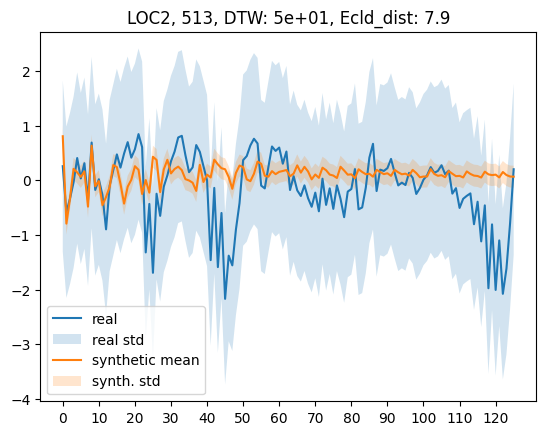

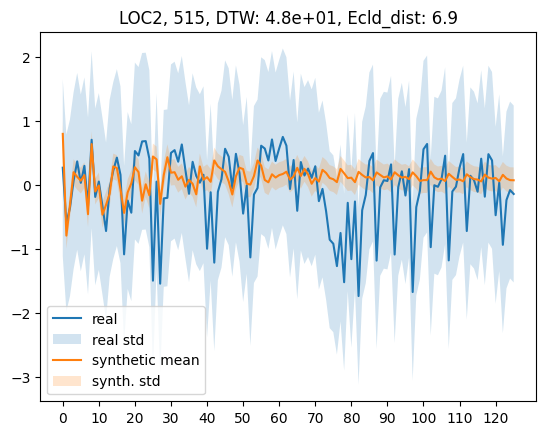

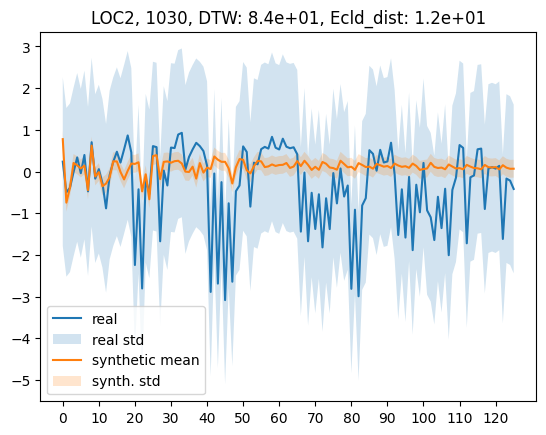

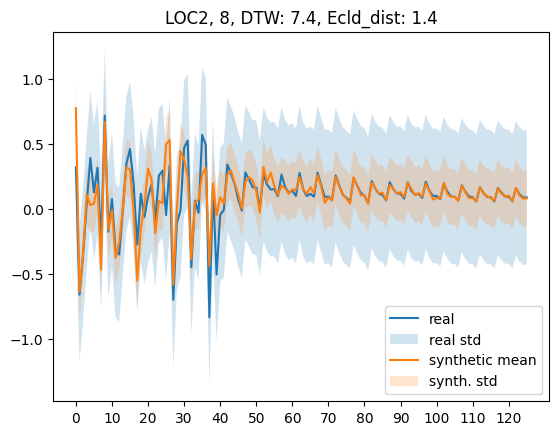

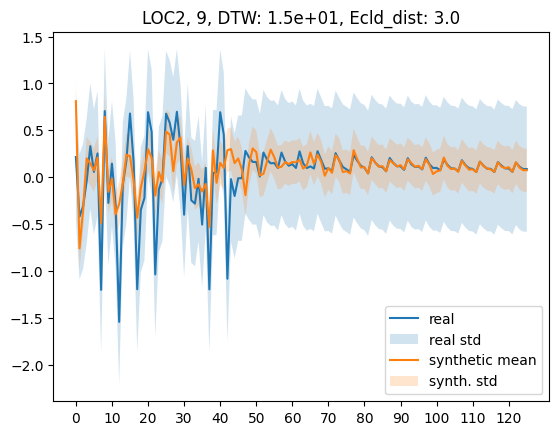

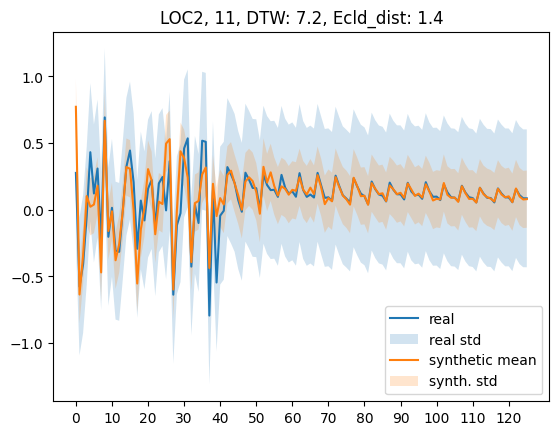

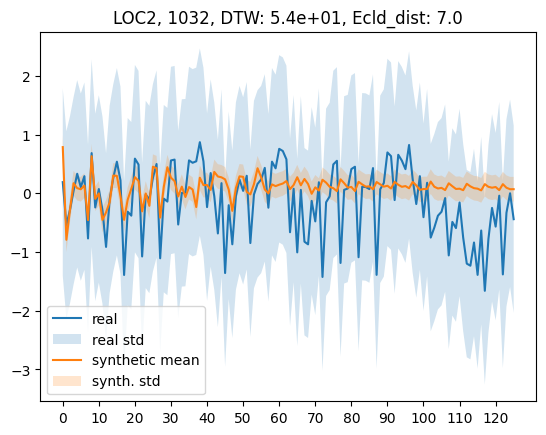

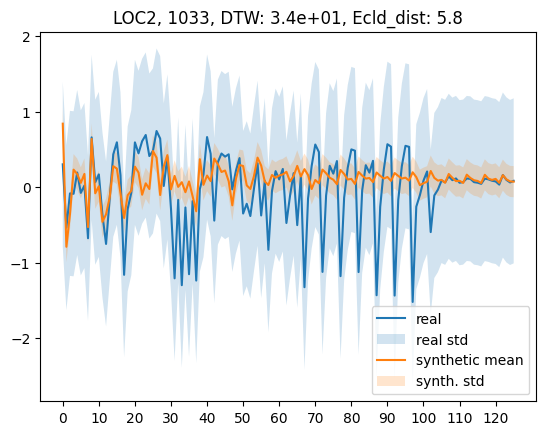

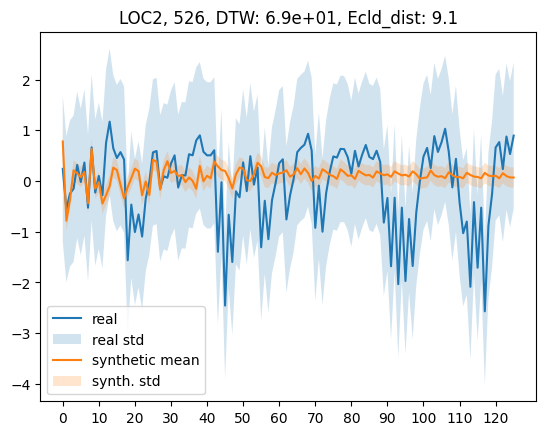

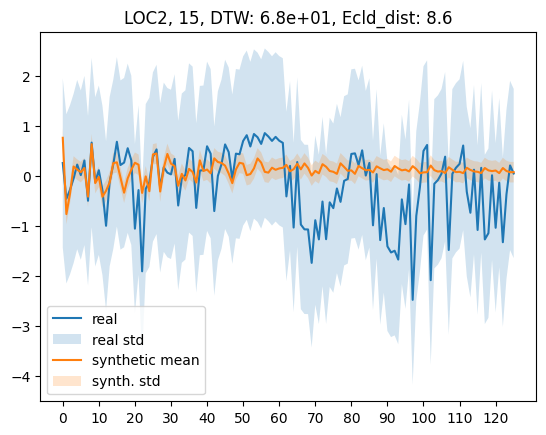

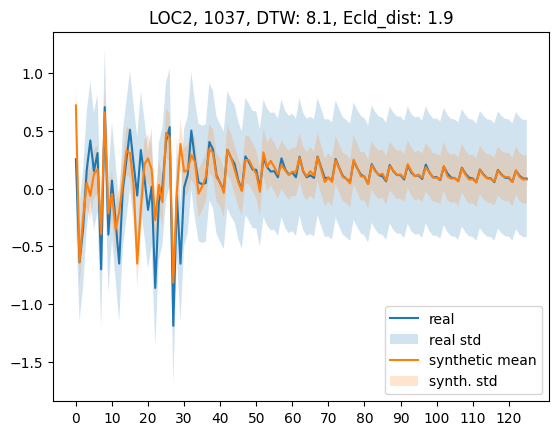

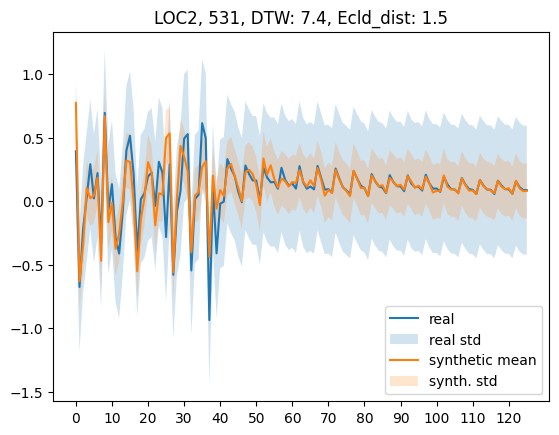

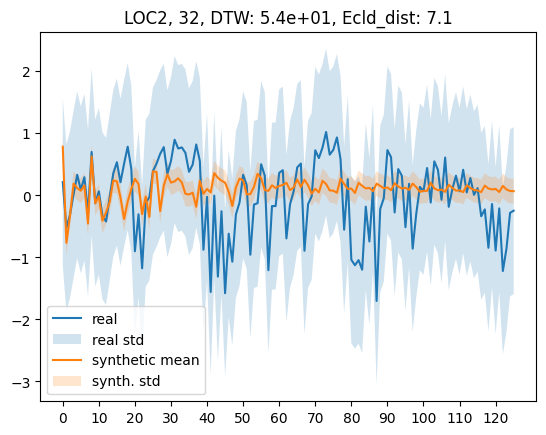

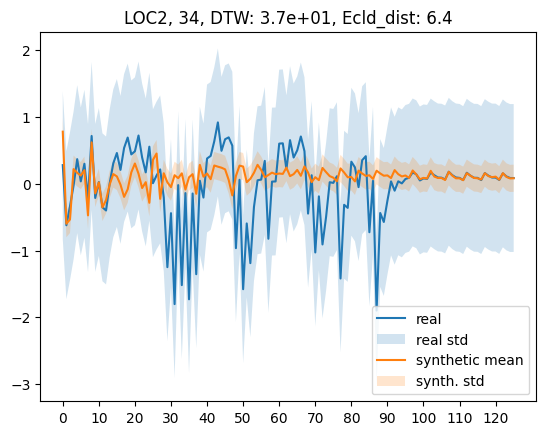

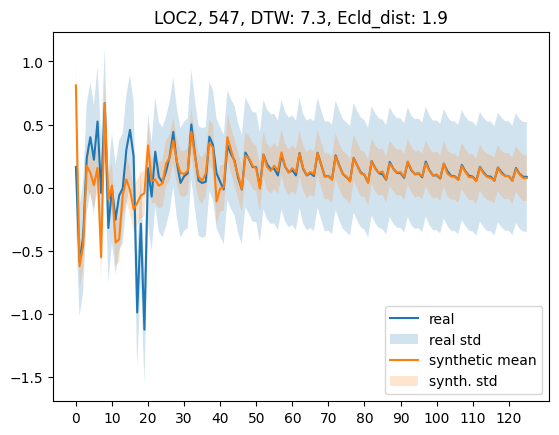

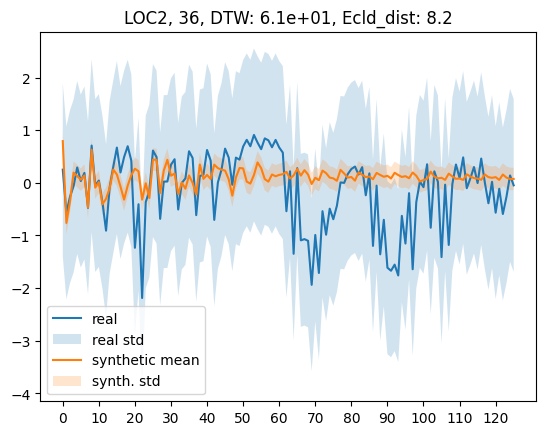

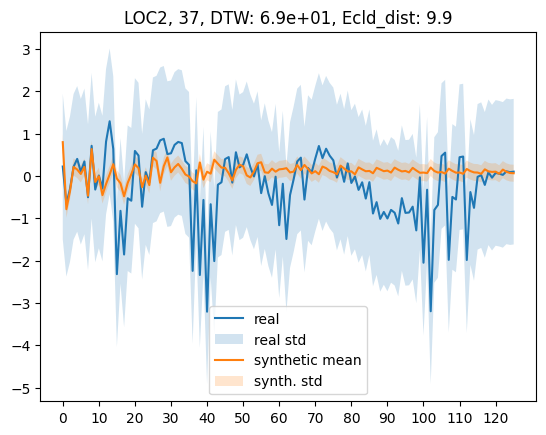

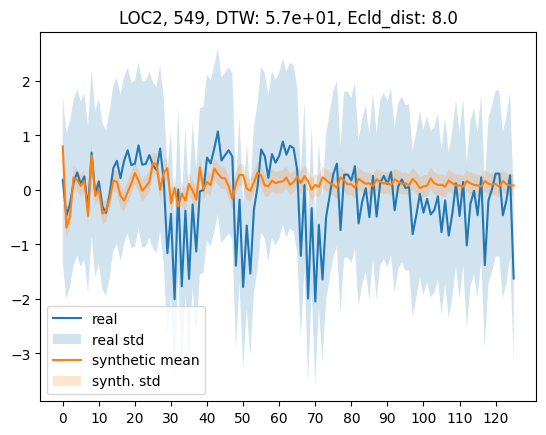

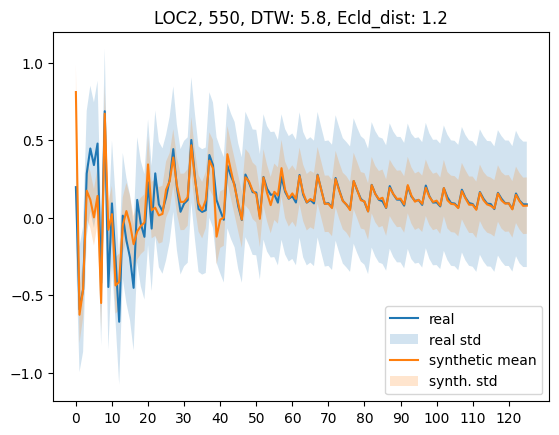

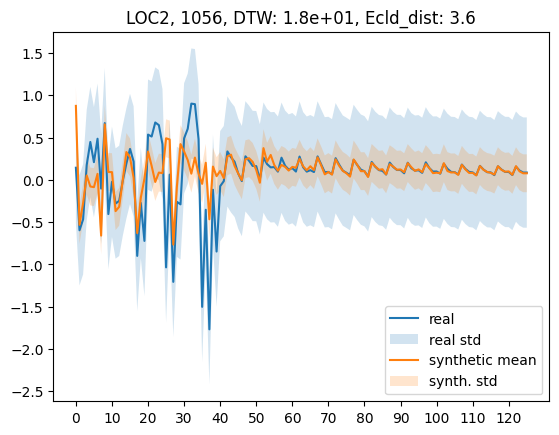

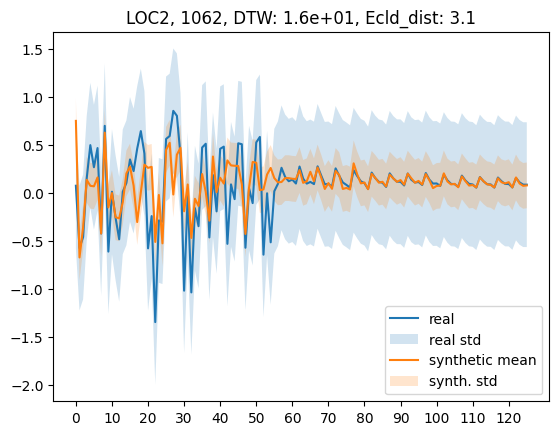

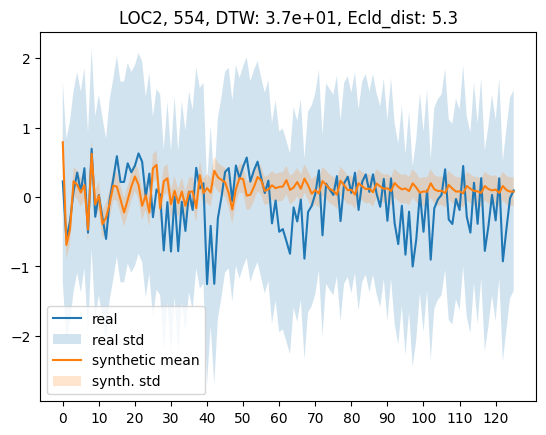

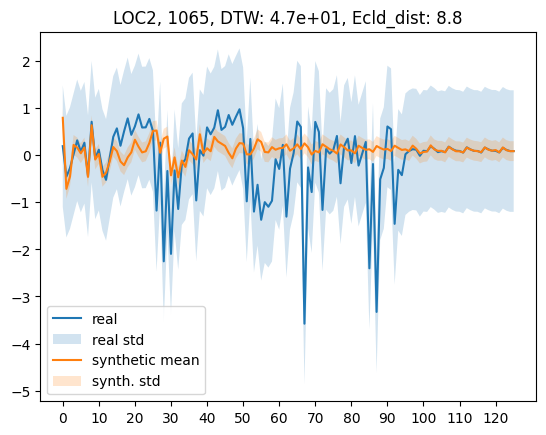

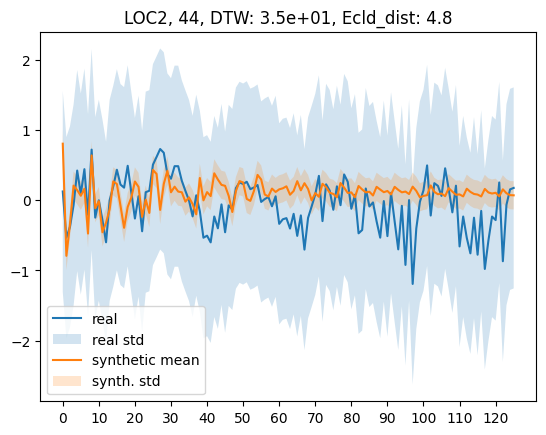

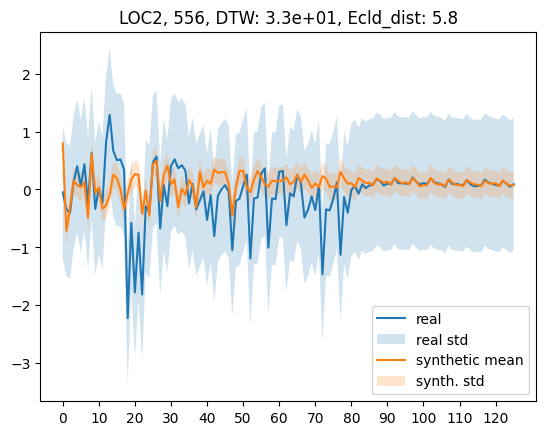

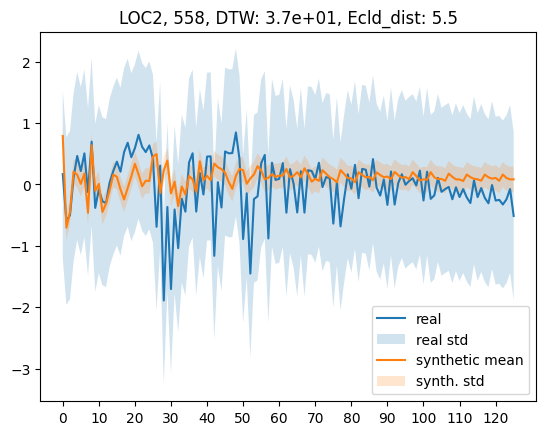

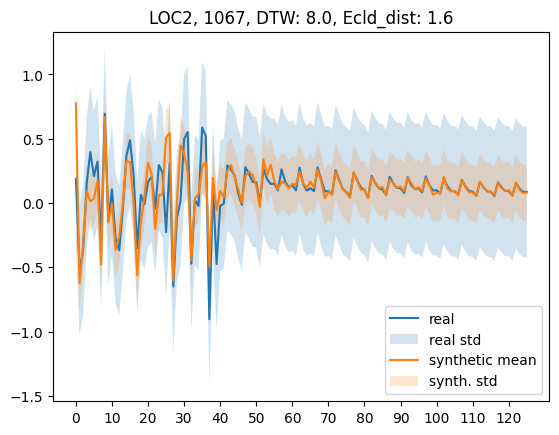

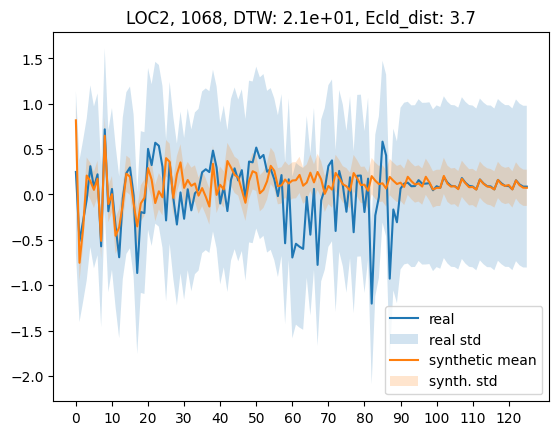

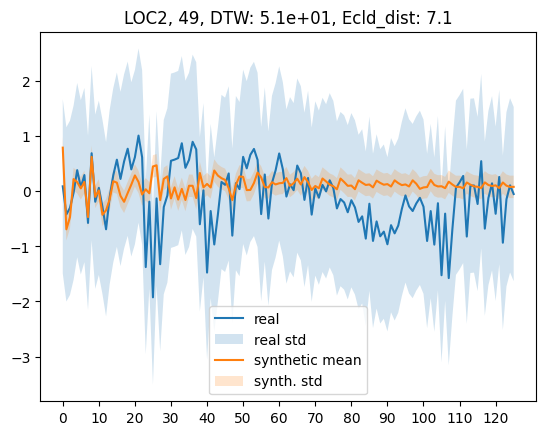

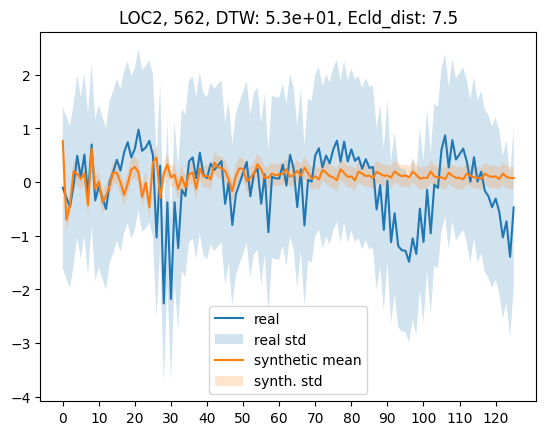

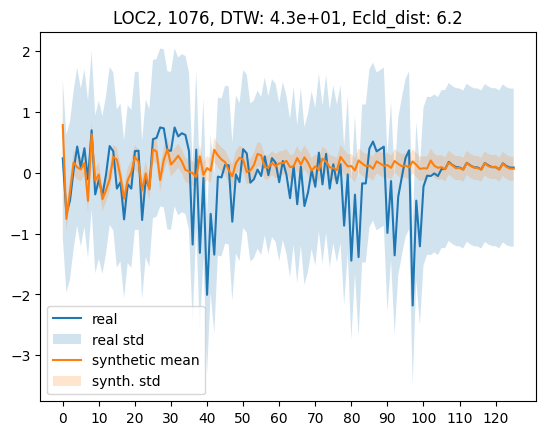

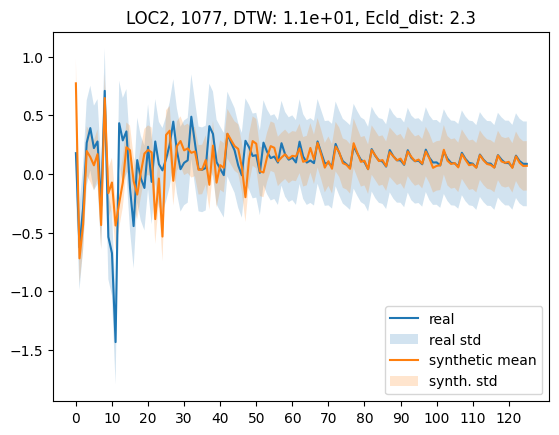

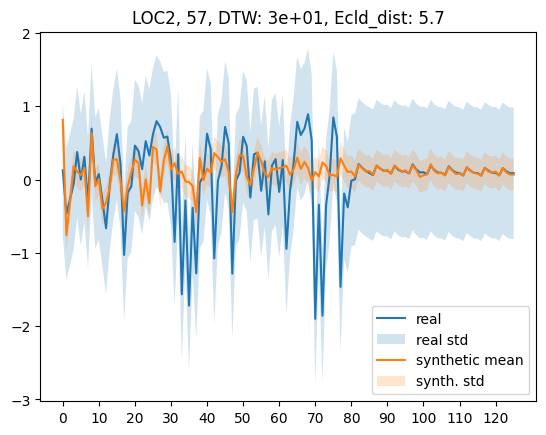

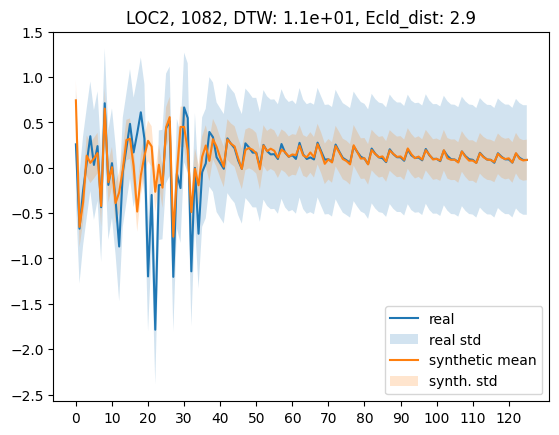

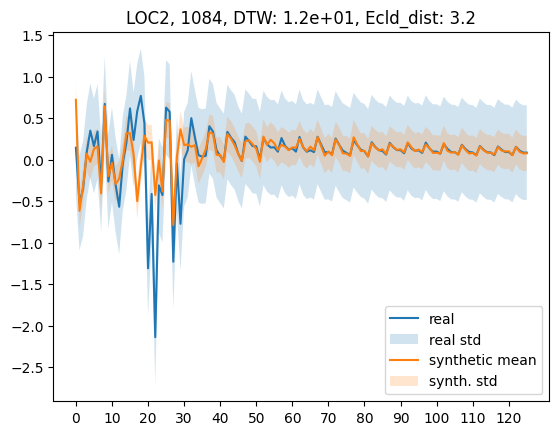

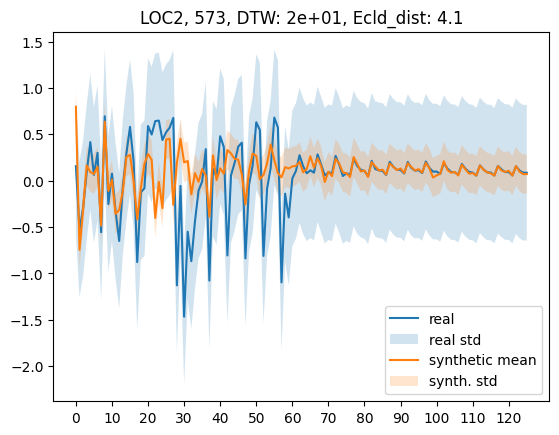

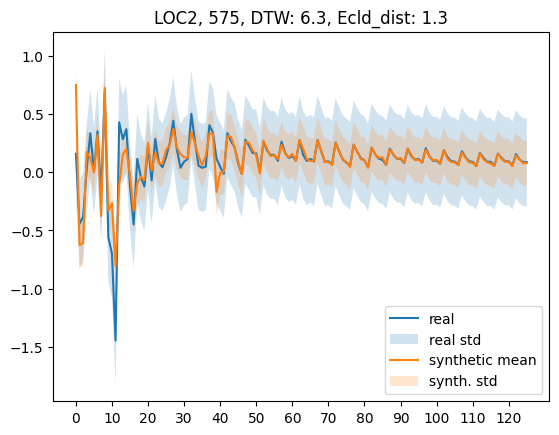

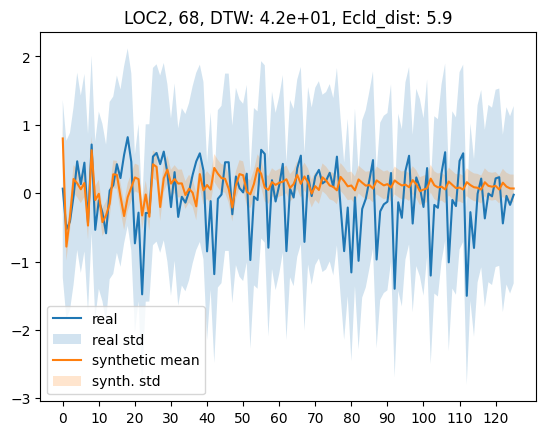

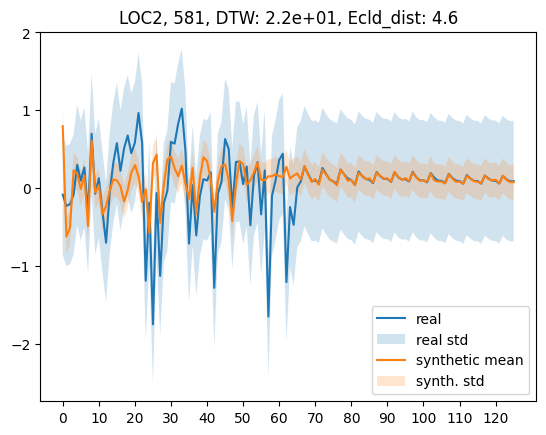

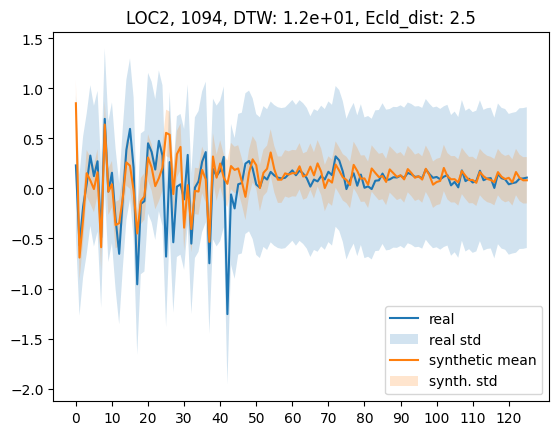

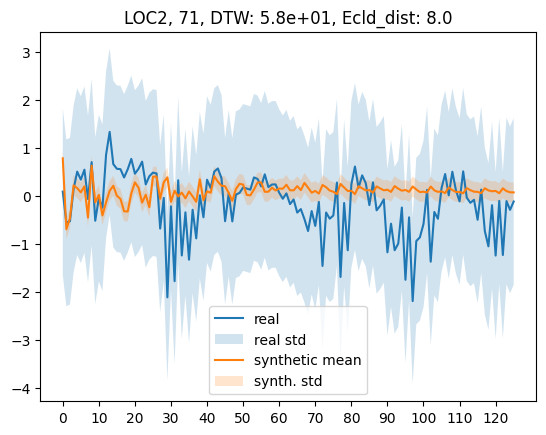

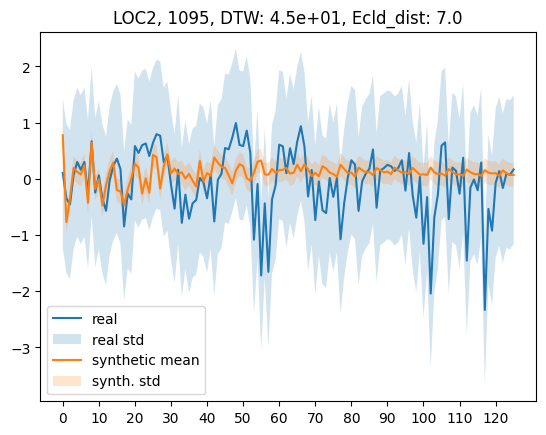

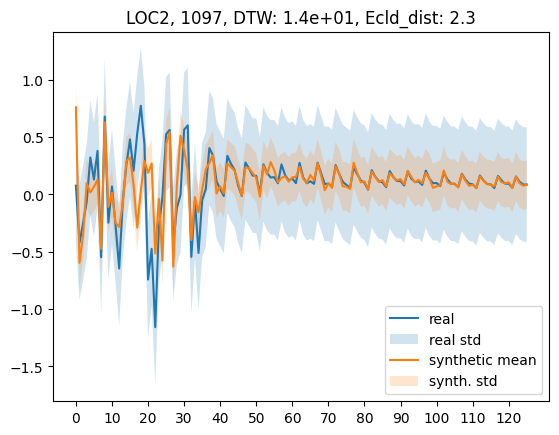

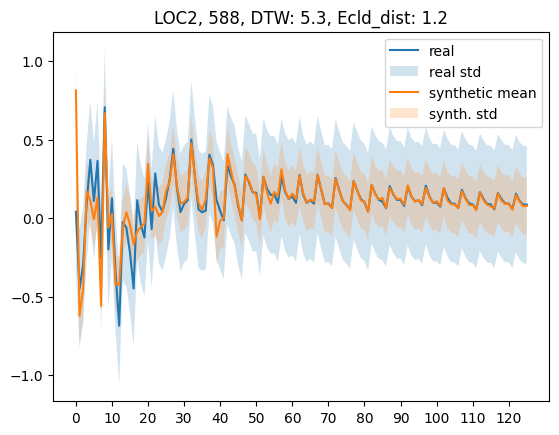

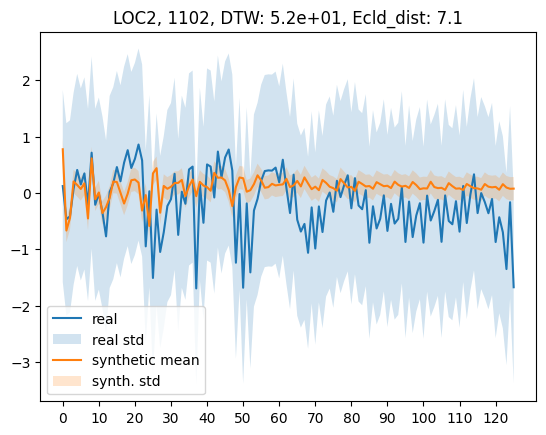

254.08434450626373


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw

import numpy as np
def get_euclidean_distance(a, b):
    return np.sqrt(np.sum(np.square(a - b)))

samples_per_website = 200

eucld_dists = []
for i in range(0, 50 * samples_per_website, samples_per_website):
    plt.figure()
    # real mean
    real_mean = np.mean(x_test_target[i:i+samples_per_website], axis=0)
    real_std = np.std(x_test_target[i:i+samples_per_website])
    
    plt.plot(real_mean, label='real')
    plt.fill_between(range(length),real_mean + real_std, real_mean - real_std, label='real std', alpha = 0.2)
    
    # synth mean
    synthetic_mean = np.mean(generated_data[i:i+samples_per_website], axis=0)
    synthetic_std = np.std(generated_data[i:i+samples_per_website])
    
    dtw_distance, path = fastdtw(real_mean, synthetic_mean, dist=get_euclidean_distance)
    euclidean_distance = get_euclidean_distance(real_mean, synthetic_mean)

    plt.plot(synthetic_mean, label='synthetic mean')
    plt.fill_between(range(length), synthetic_mean + synthetic_std, synthetic_mean - synthetic_std, label='synth. std', alpha = 0.2)
    
    
    plt.xticks(range(0,length, 10), labels=range(0, length, 10))
    plt.title(f"{output_domain}, {test_web_samples[i // samples_per_website]}, DTW: {dtw_distance:.2}, Ecld_dist: {euclidean_distance:.2}")
    plt.legend()
    plt.show()
    eucld_dists.append(euclidean_distance)
    

print(sum(eucld_dists))